In [1]:
import pandas as pd

## 0. Import et mise en forme de la data

### 0.1 Importation

In [2]:
DATA_PATH = './../data/'

df = pd.read_csv(f'{DATA_PATH}household_power_consumption.txt',
                   sep=';',                            # separateur = ;
                   header=0,                           # ligne des header = 1ère ligne
                   low_memory=False,                   # parsing complet
                   infer_datetime_format=True,         # parsing des dates
)

In [3]:
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0


### 0.2 Mise en forme des dtypes de date et création des variables de temps

In [4]:
# Combiner les colonnes 'Date' et 'Time' en une seule colonne datetime
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Définir la colonne 'datetime' comme index
df = df.set_index('datetime')

In [5]:
#Convertir les colonnes souhaitées en valeurs numériques, avec les valeurs non convertibles définies sur NaN.
cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df = df.dropna()
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')


In [6]:
# Convertir la colonne 'Date' en format datetime
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

# Extraire les composants jour, mois et année de la colonne 'Date'
df = df.assign(day=df['Date'].dt.day, month=df['Date'].dt.month, year=df['Date'].dt.year)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year
datetime,,,,,,,,,,,,
2006-12-16 17:24:00,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,16,12,2006
2006-12-16 17:25:00,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,16,12,2006
2006-12-16 17:26:00,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,16,12,2006
2006-12-16 17:27:00,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,16,12,2006
2006-12-16 17:28:00,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,16,12,2006


## 1. Explication du problème de machine learning que vous souhaitez résoudre

## 2. Présentation du jeu de données


Le jeu de données contient des mesures de la consommation d'électricité dans un foyer avec un taux d'échantillonnage d'une minute. Les données ont été collectées sur une période de presque 4 ans, de décembre 2006 à novembre 2010.

Le jeu de données compte un total de 2 075 259 observations avec 12 colonnes.

Les colonnes dans le jeu de données comprennent :

- Date : La date à laquelle l'observation a été enregistrée.
- Time : L'heure à laquelle l'observation a été enregistrée.
- Global_active_power : La puissance active totale consommée par le foyer en kilowatts.
- Global_reactive_power : La puissance réactive totale consommée par le foyer en kilowatts.
- Voltage : La tension en volts.
- Global_intensity : L'intensité de courant totale en ampères.
- Sub_metering_1 : L'énergie active consommée par la cuisine en watt-heures.
- Sub_metering_2 : L'énergie active consommée par la buanderie en watt-heures.
- Sub_metering_3 : L'énergie active consommée par un chauffe-eau électrique et un climatiseur en watt-heures.
- day : Le jour du mois où l'observation a été enregistrée.
- month : Le mois de l'année où l'observation a été enregistrée.
- year : L'année où l'observation a été enregistrée.

Le jeu de données contient certaines valeurs manquantes qui sont identifiées dans la sortie de la fonction print_exhaustive_presentation().

Le jeu de données peut être utilisé pour explorer les motifs et les tendances de la consommation d'électricité domestique, et peut être utilisé pour la prévision et la détection d'anomalies.

In [7]:
import pandas as pd

def print_basic_presentation(data):
    # Print column names
    print("Column Names:")
    print(list(data.columns))
    print()

    # Print data types
    print("Data Types:")
    display(data.dtypes.to_frame().T)
    print()

    # Print basic statistics
    print("Basic Statistics:")
    display(data.describe())
    print()

    # Print missing values
    missing_values_count = data.isna().sum()
    if missing_values_count.sum() > 0:
        print("Missing Values:")
        display(missing_values_count.to_frame().T)
        print()
    else:
        print("No missing values found.\n")

    # Print unique values for categorical features
    categorical_features = ["day", "month", "year"]
    for feature in categorical_features:
        unique_values = data[feature].unique()
        print(f"Unique values for {feature}:")
        print(unique_values)
        print()

    # Print sample data
    print("Sample Data:")
    display(data.head())
    print()


In [8]:
print_basic_presentation(df)


Column Names:
['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'day', 'month', 'year']

Data Types:


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year
0,datetime64[ns],object,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64



Basic Statistics:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,1.571245e+01,6.454433e+00,2.008425e+03
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,8.801670e+00,3.423209e+00,1.124388e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.006000e+03
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,3.000000e+00,2.007000e+03
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.600000e+01,6.000000e+00,2.008000e+03
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,2.300000e+01,9.000000e+00,2.009000e+03
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,3.100000e+01,1.200000e+01,2.010000e+03



No missing values found.

Unique values for day:
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  1  2  3  4  5  6  7  8
  9 10 11 12 13 14 15]

Unique values for month:
[12  1  2  3  4  5  6  7  8  9 10 11]

Unique values for year:
[2006 2007 2008 2009 2010]

Sample Data:


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day,month,year
datetime,,,,,,,,,,,,
2006-12-16 17:24:00,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,16,12,2006
2006-12-16 17:25:00,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,16,12,2006
2006-12-16 17:26:00,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,16,12,2006
2006-12-16 17:27:00,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,16,12,2006
2006-12-16 17:28:00,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,16,12,2006


## 3. Exploration du jeu de données (Analyse descriptive, statistiques descriptives, visualisation)

### 3.0 Resampling des données

In [10]:
# Groupes pour le resampling
daily_groups = df.resample('D')
weekly_groups = df.resample('W')

# Jeux de données resamplés
daily_data = daily_groups.sum()
weekly_data = weekly_groups.sum()


/var/folders/4l/60lgrf9s6sqbf6lcr70gbl2c0000gn/T/ipykernel_68755/3308129971.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_data = daily_groups.sum()
/var/folders/4l/60lgrf9s6sqbf6lcr70gbl2c0000gn/T/ipykernel_68755/3308129971.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_data = weekly_groups.sum()


### 3.1 Statistiques générales 

In [ ]:
import sys
sys. append

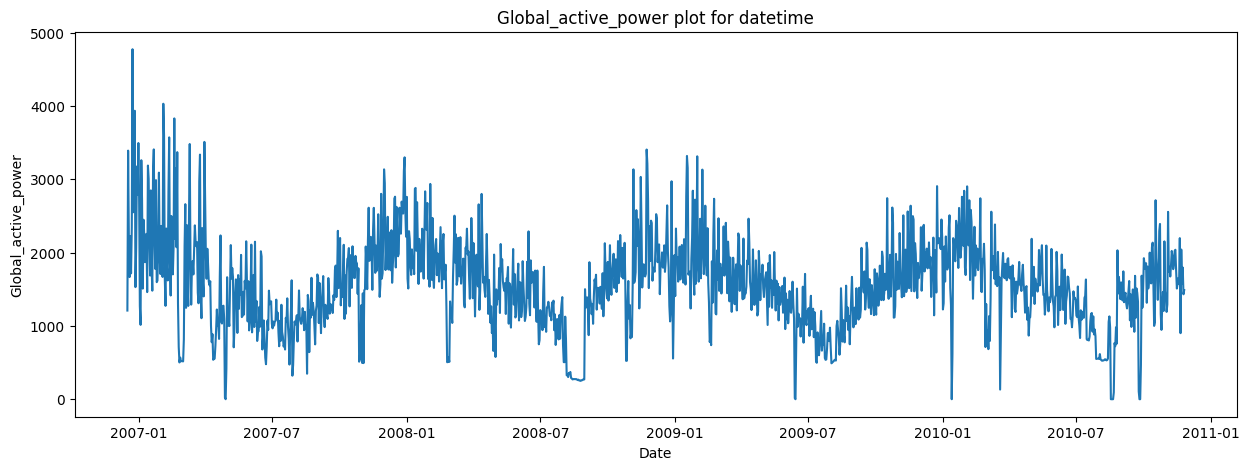

In [42]:
# Plotting de la puissance totale par jour
plot_data(daily_data, 'Global_active_power')

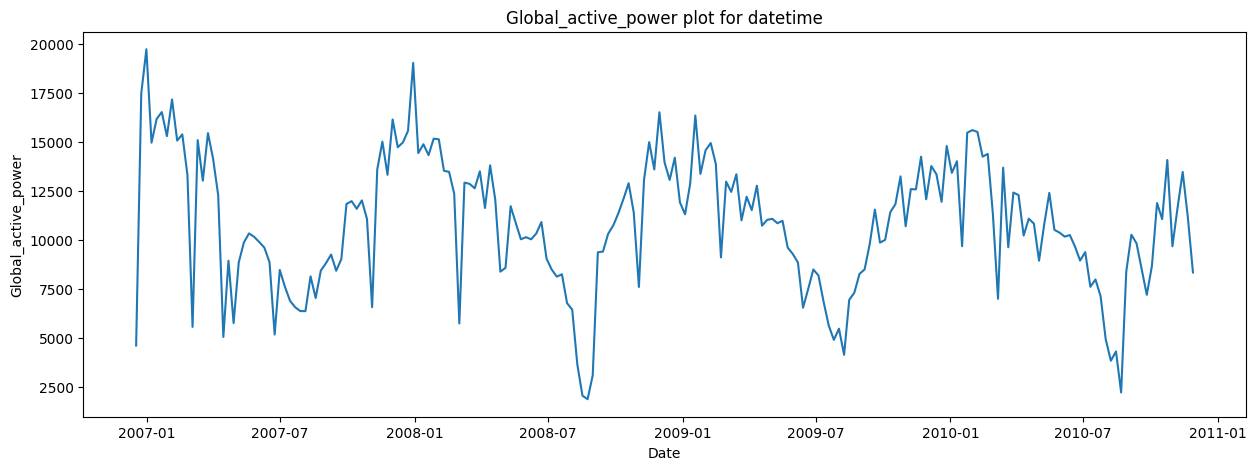

In [43]:
# Plotting de la puissance totale par semaine
plot_data(weekly_data, 'Global_active_power')

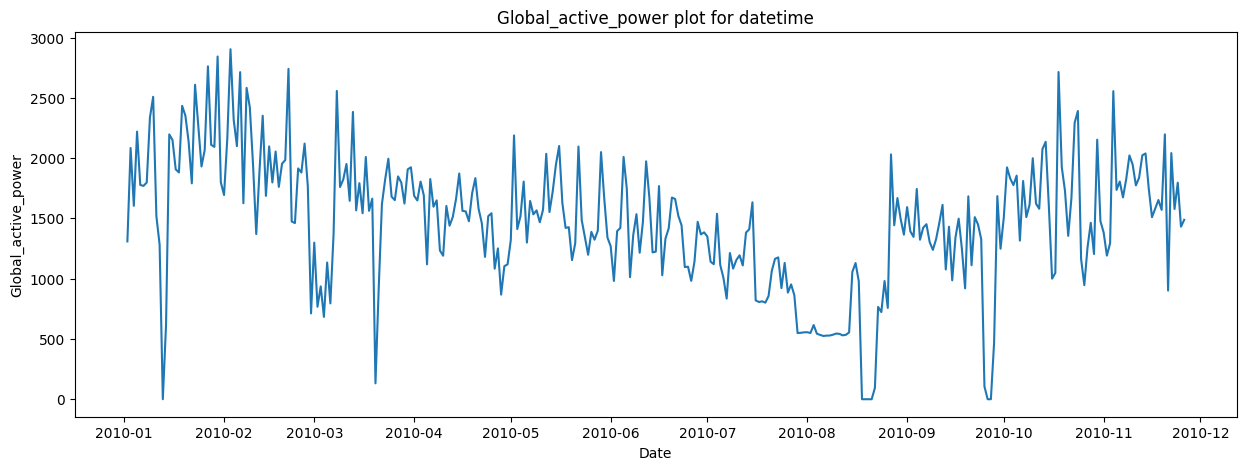

In [44]:

# Filtre sur les dates des données de la dernière année
mask = (daily_data.index > '2010-01-01') & (daily_data.index < '2011-01-01')

# Plotting de la puissance totale quotidienne pour 2010
plot_data(daily_data.loc[mask], 'Global_active_power')


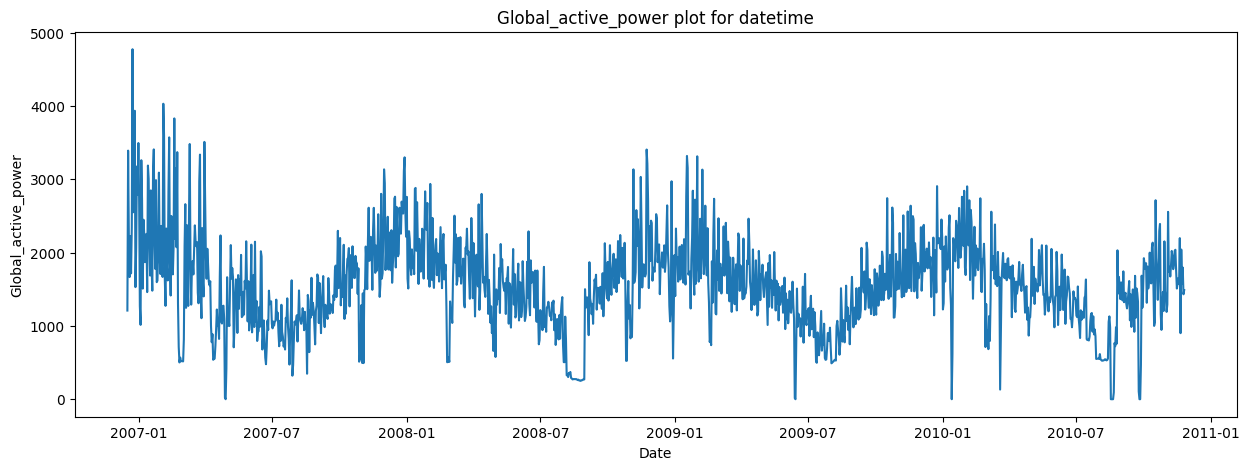

In [45]:
# Suppression de la feature voltage et year pour observer les autres features
suppressed_data = daily_data.drop(columns=['Voltage','year'])
plot_data(suppressed_data, 'Global_active_power')


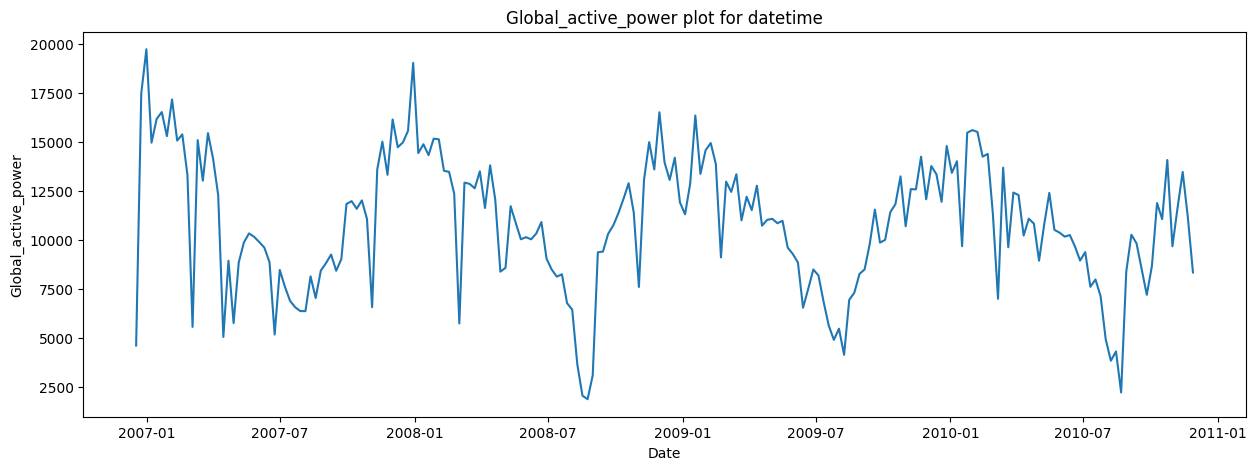

In [46]:

# Suppression de la feature voltage pour observer les autres features weekly
wk_suppressed_data = weekly_data.drop(columns=['Voltage','year'])
plot_data(wk_suppressed_data, 'Global_active_power')


[Text(0.5, 1.0, 'Distribution of Global_active_power'),
 Text(0.5, 0, 'Global_active_power'),
 Text(0, 0.5, 'Density')]

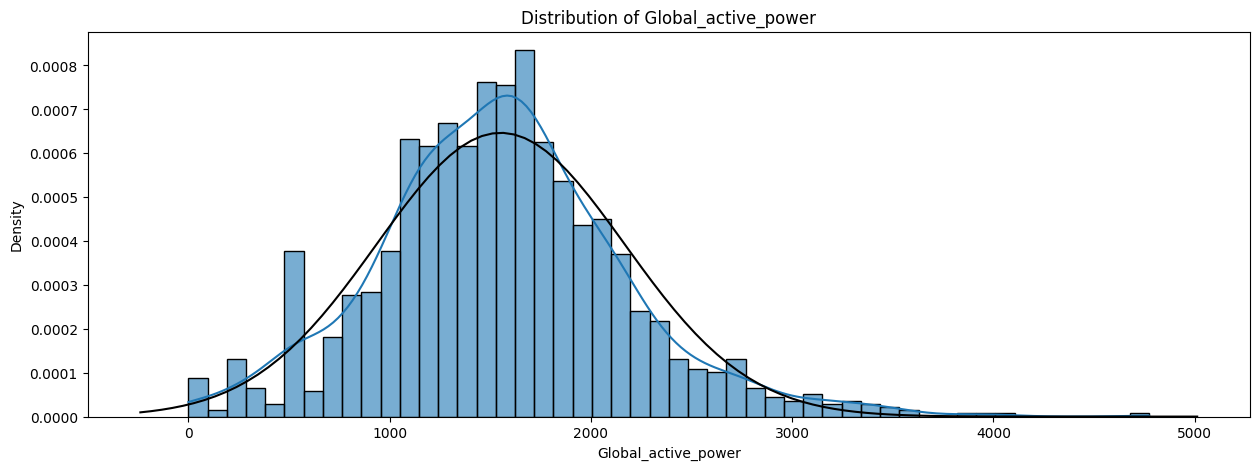

In [47]:

# Observation de la distribution de la puissance par rapport à une distribution Gaussienne
plt.figure(figsize=(15,5))
ax = sns.histplot(data=daily_data['Global_active_power'], bins=50, kde=True, stat="density", alpha=0.6)
mu, sigma = stats.norm.fit(daily_data['Global_active_power'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
sns.lineplot(x=x, y=p, color='black')
ax.set(title='Distribution of Global_active_power', xlabel='Global_active_power', ylabel='Density')


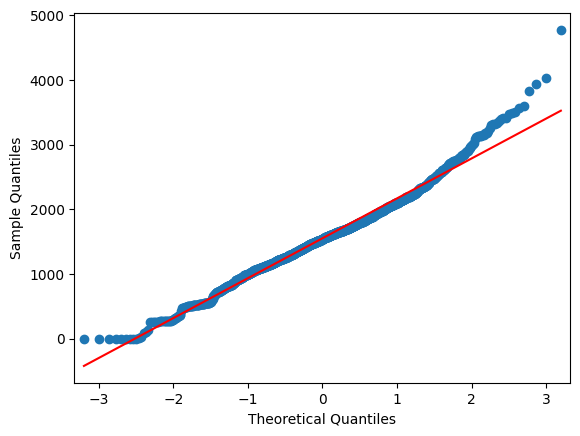

In [48]:
# Add probability plot for the column
qq = ProbPlot(daily_data['Global_active_power']).qqplot(line='s')

In [51]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Pandas Profiling Report")

profile.to_widgets()

PermissionError: [Errno 1] Operation not permitted

## 4. Data cleaning et imputation de données manquantes (si nécessaire)

## 5. Feature engineering en expliquant votre démarche et les variables créées

## 6. Préparation des données pour être fournies à un modèle de prévision ML/DL

## 7. Sélection de différents modèles (explications des critères de sélection, choix de la métrique...)

## 8. Evaluation de la performance des modèles (recherche d'hyperparamètres, contrôle de l’overfitting, comparaison des performances) sur différents horizons de prédiction

## 9. Discussion autour de la performance des modèles


## 10. Synthèse et conclusions, pistes d’améliorations envisagées